In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import  Sequential,load_model, Model, save_model
from tensorflow.keras.layers import *
from tensorflow.keras import callbacks as cb

In [3]:
from tensorflow.keras.datasets import cifar100
# Load CIFAR-100 dataset
(x_trainCipher, y_trainCipher), (x_testCipher, y_testCipher) = cifar100.load_data()

# Normalize the pixel values between 0 and 1
x_trainCipher = x_trainCipher.astype('float32') / 255.0
x_testCipher = x_testCipher.astype('float32') / 255.0

X_train= np.vstack([x_trainCipher,x_testCipher])
Y_train= np.vstack([y_trainCipher,y_testCipher])
sorted_train_indices = np.argsort(Y_train.flatten())
X_train = X_train[sorted_train_indices]
y_Cipher = Y_train[sorted_train_indices]

X_train= np.reshape(X_train, (-1,600,32,32,3))
print(X_train.shape)
#del x_trainCipher, x_testCipher, y_trainCipher,y_testCipher

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
(100, 600, 32, 32, 3)


In [4]:
import random
class Data_GeneratorIncremental(tf.keras.utils.Sequence):
    def __init__(self, data='cipher', way = 5,  k3=0,k4=500, shot = 2, num_batch=1):
        self.data=X_train
        self.dim=[32,32,3]; self.dimResize=[36,36]
        self.k3=k3; self.k4=k4 # from, to # 0-500: training, 500:600 valdiation & testing
        self.num_batch = num_batch
        self.n_classes = len(self.data)
        self.on_epoch_end()
        self.way = way
        self.shot = shot

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.num_batch
    def __getitem__(self,index):
        'Generate one batch of data'
        X_sample,label= self.__data_generation()
        return X_sample, label

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        pass

    def __data_generation(self):
        X_sample = []; X_sample1 = [];
        label = np.zeros((self.way,100))

        idx = list(np.arange(0,100))
        #if(len(idx)> self.way):
        idx = random.sample(idx, self.way) #selected_classes

        for i in range(len(idx)):
            X_temp = [];
            sample_idx1 = random.sample(list(np.arange(self.k3,self.k4)), self.shot)
            for s in range(self.shot):
              img = self.data[idx[i]][sample_idx1[s]]
              image = tf.image.resize(img, self.dimResize)
              imgc = tf.image.random_crop(image, size=self.dim)
              imgf = tf.image.random_flip_left_right(imgc)
              #img1=random.sample([img,imgf], 1)[0]   #np.flip(img,1),random_crop(img)
              X_sample.append(imgf)
              X_sample.append(img)
              #label[i*self.shot+s,idx[i]]= 1
            label[i,idx[i]]= 1
        return  np.array(X_sample), label

train_way = 60
shot = 1
val_loader= Data_GeneratorIncremental(way = train_way, k3=0,k4=500,shot=shot,num_batch= 1)

x, z= val_loader[0]
print(x.shape,  z.shape)
#print(z)


(120, 32, 32, 3) (60, 100)


In [5]:
!pip install git+https://github.com/qubvel/classification_models.git
!pip install keras_applications
from classification_models.keras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')

dim=(32,32,3)
base_model = ResNet18(input_shape=dim, weights='imagenet', include_top=False)
out1=tf.keras.layers.Dropout(0.3)(base_model.output)

out2=tf.keras.layers.Flatten()(out1)
resnet18 = Model(inputs=base_model.input, outputs=out2)


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-uh3mntyc
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-uh3mntyc
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00
  Created wheel for image_classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20029 sha256=4542651bb1eb91eab12dbaa61c2af765e6dc62bcdfc5da3cf7be31cbf371ed68
  Stored in directory: /tmp/pip-ephem-wheel-cache-qr38a0wc/wheels/f5/13/cb/b1dbd79043c5a389742e422859b0b663adcd7b5c220928c339
Successfully built image_classifiers
44920640/44920640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
train_way = 50
shot = 1
lr=0.001

base_model = ResNet18(input_shape=dim, weights='imagenet', include_top=False)
out1=tf.keras.layers.Dropout(0.3)(base_model.output)
out2=tf.keras.layers.Flatten()(out1)
resnet18 = Model(inputs=base_model.input, outputs=out2)

def reduce_tensor1(xx):
    return tf.reduce_mean(tf.reshape(xx,(-1,2,xx.shape[-1])), axis=1)

def scheduler(epoch):
    global lr
    if (epoch+1) %10== 0:
        lr/= 2
    return lr

if __name__ == "__main__":
    input_shape = (32,32,3)
    sample = Input(input_shape)
    out_feature1 = resnet18(sample)
    out_feature1 = Lambda(reduce_tensor1, name="out_feature1")(out_feature1)
    #.........................................................
    pred=tf.keras.layers.Dense(100,'softmax')(out_feature1)

    resNetProto = Model(sample, pred)
    optimizer = Adam(0.001)

    resNetProto.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    print(resNetProto.summary())
 #.........................................................................................
    train_loader = Data_GeneratorIncremental(way = train_way,  data ='cipher', k3=0,k4=500, shot = shot, num_batch=100)
    val_loader = Data_GeneratorIncremental(way = train_way,  data ='cipher', k3=500,k4=600, shot = shot, num_batch=10)

    reduce_lr = cb.ReduceLROnPlateau(monitor = 'loss', factor = 0.5,patience = 10, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor='val_loss', patience=15)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard()

    history = resNetProto.fit(train_loader,epochs = 50, batch_size=16,validation_data = val_loader, shuffle=True, callbacks=[ lr_sched,reduce_lr, stopping,tensorboard])


Model: "functional_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_110 (Functional)     │ (None, 512)            │    11,186,889 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_feature1 (Lambda)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,238,189 (42.87 MB)

 Trainable params: 11,230,247 (42.84 MB)

 Non-trainable params: 7,942 (31.02 KB)

None
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 36s 194ms/step - accuracy: 0.1044 - loss: 4.4584 - val_accuracy: 0.0080 - val_loss: 4.8888 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step - accuracy: 0.2834 - loss: 2.9505 - val_accuracy: 0.0180 - val_loss: 6.4831 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step - accuracy: 0.3241 - loss: 2.6779 - val_accuracy: 0.0080 - val_loss: 6.1161 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step - accuracy: 0.3673 - loss: 2.4588 - val_accuracy: 0.0120 - val_loss: 6.7075 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 183ms/step - accuracy: 0.4061 - loss: 2.3176 - val_accuracy: 0.0040 - val_loss: 6.3371 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 180ms/step - accuracy: 0.4229 - loss: 2.2148 - val_accuracy: 0.0200 - val_loss: 6.6186 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step - accuracy

In [8]:
def conv_net(dim):
    convnet = Sequential()
    convnet.add(Conv2D(64,(3,3),padding='valid',input_shape=dim))
    convnet.add(BatchNormalization())
    convnet.add(Activation('relu'))
    convnet.add(MaxPooling2D())
    for i in range(3):
        convnet.add(Conv2D(64,(3,3),padding='same',input_shape=dim))
        convnet.add(BatchNormalization())
        convnet.add(Activation('relu'))
        convnet.add(MaxPooling2D())
        #convnet.add(tf.keras.layers.Attention())
    convnet.add(Flatten())
    return convnet

train_way = 50
shot = 1
lr=0.001

def reduce_tensor1(xx):
    return tf.reduce_mean(tf.reshape(xx,(-1,2,xx.shape[-1])), axis=1)

def scheduler(epoch):
    global lr
    if (epoch+1) %10== 0:
        lr/= 2
    return lr

dim  = (32,32,3)
cnn4 = conv_net(dim)
if __name__ == "__main__":
    input_shape = (32,32,3)
    sample = Input(input_shape)
    out_feature1 = cnn4(sample)
    out_feature1 = Lambda(reduce_tensor1, name="out_feature1")(out_feature1)
    #.........................................................
    pred=tf.keras.layers.Dense(100,'softmax')(out_feature1)

    cnn_4 = Model(sample, pred)
    optimizer = Adam(0.001)
    cnn_4.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    print(cnn_4.summary())
 #.........................................................................................
    train_loader = Data_GeneratorIncremental(way = train_way,  data ='cipher', k3=0,k4=500, shot = shot, num_batch=100)
    val_loader = Data_GeneratorIncremental(way = train_way,  data ='cipher', k3=500,k4=600, shot = shot, num_batch=10)

    reduce_lr = cb.ReduceLROnPlateau(monitor = 'loss', factor = 0.5,patience = 10, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor='val_loss', patience=15)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard()

    history1 = cnn_4.fit(train_loader,epochs = 50, batch_size=16,validation_data = val_loader, shuffle=True, callbacks=[ lr_sched,reduce_lr, stopping,tensorboard])


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 64)             │       113,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_feature1 (Lambda)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │         6,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,100 (469.14 KB)

 Trainable params: 119,588 (467.14 KB)

 Non-trainable params: 512 (2.00 KB)

None
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - accuracy: 0.0410 - loss: 4.5457 - val_accuracy: 0.0240 - val_loss: 4.6240 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.0947 - loss: 4.0052 - val_accuracy: 0.0200 - val_loss: 5.1491 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.1365 - loss: 3.6974 - val_accuracy: 0.0260 - val_loss: 4.8154 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.1604 - loss: 3.5431 - val_accuracy: 0.0340 - val_loss: 4.6041 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 0.2087 - loss: 3.3237 - val_accuracy: 0.1240 - val_loss: 3.7235 - learning_rate: 0.0010
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.2069 - loss: 3.2540 - val_accuracy: 0.2200 - val_loss: 3.4104 - learning_rate: 0.0010
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - accuracy

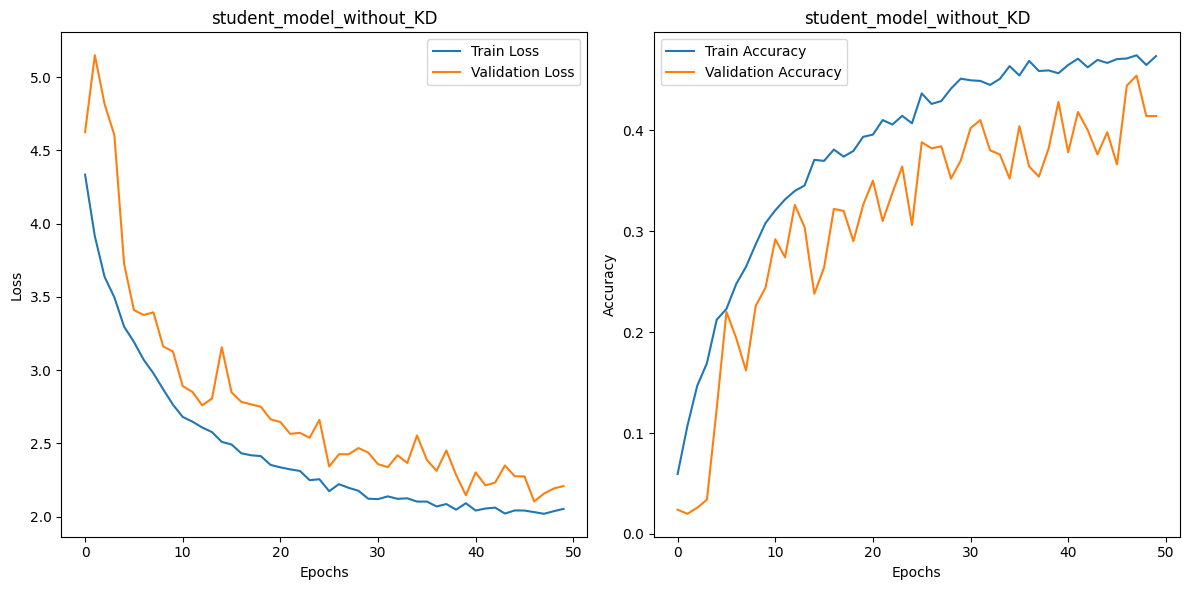

In [15]:
import matplotlib.pyplot as plt
def plot_training_history(history):
    # Loss plot

    history_dict = history.history
    plt.figure(figsize=(12, 6))

    # Training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['loss'], label='Train Loss')
    plt.plot(history_dict['val_loss'], label='Validation Loss')
    plt.title('student_model_without_KD')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['accuracy'], label='Train Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.title('student_model_without_KD')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
# history = {'train_loss': [0.5, 0.3, 0.2], 'val_loss': [0.6, 0.4, 0.35], 'train_accuracy': [0.7, 0.85, 0.9], 'val_accuracy': [0.65, 0.8, 0.85]}
plot_training_history(history1)

In [10]:
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import Model
import tensorflow.keras.callbacks as cb
import numpy as np

class Data_GeneratorDistill(tf.keras.utils.Sequence):
    def __init__(self, data='cipher', way = 5,  k3=0,k4=500, shot = 2, num_batch=1):
        self.data=X_train  # Assuming X_train is your dataset
        self.dim=[32,32,3]; self.dimResize=[36,36]
        self.k3=k3; self.k4=k4 # from, to # 0-500: training, 500:600 valdiation & testing
        self.num_batch = num_batch
        self.n_classes = 100
        self.on_epoch_end()
        self.way = way
        self.shot = shot

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.num_batch

    def __getitem__(self,index):
        'Generate one batch of data'
        X_sample, label, label2 = self.__data_generation()
        # Note: Return separate labels for the two losses
        return X_sample, (label, label2)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        pass

    def __data_generation(self):
        X_sample = [];
        label = np.zeros((self.way * self.shot, 100))  # Shape (way * shot, 100)
        label2 = np.eye((self.way * self.shot)) # Shape (way * shot, way * shot)

        idx = list(np.arange(0,100))
        idx = random.sample(idx, self.way) #selected_classes

        for i in range(len(idx)):
            X_temp = [];
            sample_idx1 = random.sample(list(np.arange(self.k3,self.k4)), self.shot)
            for s in range(self.shot):
              img = self.data[idx[i]][sample_idx1[s]]
              image = tf.image.resize(img, self.dimResize)
              imgc = tf.image.random_crop(image, size=self.dim)
              imgf = tf.image.random_flip_left_right(imgc)
              #img1=random.sample([img,imgf], 1)[0]   #np.flip(img,1),random_crop(img)
              X_sample.append(imgf)
              X_sample.append(img)
              # Assign labels correctly for both losses
              label[i * self.shot + s, idx[i]] = 1
              label2[i * self.shot + s, i * self.shot + s] = 1
        return  np.array(X_sample), label,label2

train_way = 50
shot = 1
val_loader= Data_GeneratorDistill(way = train_way, k3=0,k4=500,shot=shot,num_batch= 1)

x, (z,z1)= val_loader[0]
print(x.shape,  z.shape,z1.shape)
print(z1)

(100, 32, 32, 3) (50, 100) (50, 50)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [11]:
def conv_net(dim):
    convnet = Sequential()
    convnet.add(Conv2D(64,(3,3),padding='same',input_shape=dim))
    convnet.add(BatchNormalization())
    convnet.add(Activation('relu'))
    convnet.add(MaxPooling2D())
    for i in range(2):
        convnet.add(Conv2D(64,(3,3),padding='same',input_shape=dim))
        convnet.add(BatchNormalization())
        convnet.add(Activation('relu'))
        convnet.add(MaxPooling2D())
        #convnet.add(tf.keras.layers.Attention())
    convnet.add(Conv2D(128,(3,3),padding='same',input_shape=dim))
    convnet.add(BatchNormalization())
    convnet.add(Activation('relu'))
    convnet.add(MaxPooling2D())
    convnet.add(Flatten())
    return convnet
dim  = (32,32,3)
cnn4 = conv_net(dim)
cnn4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 512)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,784 (589.00 KB)

 Trainable params: 150,144 (586.50 KB)

 Non-trainable params: 640 (2.50 KB)

In [12]:
train_way = 50
shot = 1
lr=0.001

def reduce_tensor1(xx):
    return tf.reduce_mean(tf.reshape(xx,(-1,2,xx.shape[-1])), axis=1)

def scheduler(epoch):
    global lr
    if (epoch+1) %10== 0:
        lr/= 2
    return lr
def cosine_distances(x):
    support, query_img=x
    normalize_a = tf.nn.l2_normalize(support,1)
    normalize_b = tf.nn.l2_normalize(query_img,1)
    distance = tf.matmul(normalize_b, tf.transpose(normalize_a)) #, transpose_b=True
    return distance

def cosine_distances_output_shape(input_shapes):
    # Get the batch size (None) and the feature dimension (100) from 'out_teach'
    batch_size = input_shapes[0][0]
    feature_dim = input_shapes[0][1]
    return (batch_size, feature_dim)
def combined_loss(y_true, y_pred):
    pred, cos = y_pred[0],y_pred[1]
    # Add a dimension to pred to make the rank 2
    pred = tf.expand_dims(pred, axis=0)
    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, pred)
    cosine_loss = -tf.reduce_mean(cos)  # Negative since we want to maximize similarity
    return 0.75 * cosine_loss + 0.25 * ce_loss

# def combined_loss(y_true, y_pred):
#     pred, cos = y_pred[0],y_pred[1]
#     ce_loss = tf.keras.losses.categorical_crossentropy(y_true, pred)
#     cosine_loss = -tf.reduce_mean(cos)  # Negative since we want to maximize similarity
#     return 0.75 * cosine_loss + 0.25 * ce_loss

dim  = (32,32,3)
cnn4 = conv_net(dim)
resNet_18 =  Model(inputs=resNetProto.input, outputs=resNetProto.layers[-2].output)
resNet_18.trainable=False
#resnet_model.trainable=False
if __name__ == "__main__":
    input_shape = (32,32,3)
    sample = Input(input_shape)
    teacher = resNet_18(sample)
    # teacher=tf.reshape(teacher, (-1,2,2,512))
    # teacher = MaxPooling2D()(teacher)
    # teacher = Flatten()(teacher)
    student = cnn4(sample)
    # out_teach = Lambda(reduce_tensor1, name="out_feature1")(teacher)
    out_stu = Lambda(reduce_tensor1, name="out_feature2")(student)

    #.........................................................
    pred=tf.keras.layers.Dense(100,'softmax')(out_stu)
    # cos= tf.nn.softmax(cosine_distances([out_teach, out_stu]), axis=1)
    cos = layers.Lambda(lambda x: tf.nn.softmax(cosine_distances(x)/2, axis=1),
                   output_shape=cosine_distances_output_shape,
                   name="cosine_softmax")([teacher, out_stu])

    # cos = Lambda(cosine_distances,output_shape=cosine_distances_output_shape, name="cosine_distance")([out_teach, out_stu])
    # cos = Softmax(axis=1, name="cosine_softmax")(cos)  # Apply softmax
    # print(out_teach.shape,out_stu.shape)
    distilModel = Model(sample, [pred,cos])
    optimizer = Adam(0.001)
    distilModel.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics=[['accuracy'], ['accuracy']])
    print(distilModel.summary())
 #.........................................................................................
    train1_loader = Data_GeneratorDistill(way = train_way,  data ='cipher', k3=0,k4=500, shot = shot, num_batch=100)
    val1_loader = Data_GeneratorDistill(way = train_way,  data ='cipher', k3=500,k4=600, shot = shot, num_batch=10)

    reduce_lr = cb.ReduceLROnPlateau(monitor = 'loss', factor = 0.5,patience = 10, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor='val_loss', patience=15)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard()

    history2 = distilModel.fit(train1_loader,epochs = 50, batch_size=16,validation_data = val1_loader, shuffle=True, callbacks=[ lr_sched,reduce_lr, stopping,tensorboard])
    # distilModel.save('Model/distilModel_ClassifierRandomCrop_Backbone_cipher100.h5')
    # saveData(history.history,'Model/distilModel_ClassifierRandomCrop_cipher100.npy')

Model: "functional_106"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 512)       │    150,784 │ input_layer_9[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out_feature2        │ (None, 512)       │          0 │ sequential_4[0][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_104      │ (None, 512)       │ 11,186,889 │ input_layer_9[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 100)       │     51,300 │ out_feature2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cosine_softmax      │ (None, 512)       │          0 │ functional_104[0… │
│ (Lambda)            │                   │            │ out_feature2[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,388,973 (43.45 MB)

 Trainable params: 201,444 (786.89 KB)

 Non-trainable params: 11,187,529 (42.68 MB)

None
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 183ms/step - cosine_softmax_accuracy: 0.0224 - dense_4_accuracy: 0.0561 - loss: 8.5059 - val_cosine_softmax_accuracy: 0.0200 - val_dense_4_accuracy: 0.0140 - val_loss: 8.8040 - learning_rate: 0.0010
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - cosine_softmax_accuracy: 0.0205 - dense_4_accuracy: 0.1495 - loss: 7.5691 - val_cosine_softmax_accuracy: 0.0240 - val_dense_4_accuracy: 0.0100 - val_loss: 9.3082 - learning_rate: 0.0010
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - cosine_softmax_accuracy: 0.0284 - dense_4_accuracy: 0.1811 - loss: 7.3195 - val_cosine_softmax_accuracy: 0.0180 - val_dense_4_accuracy: 0.0280 - val_loss: 8.9708 - learning_rate: 0.0010
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 165ms/step - cosine_softmax_accuracy: 0.0259 - dense_4_accuracy: 0.2324 - loss: 7.1246 - val_cosine_softmax_accuracy: 0.0220 - val_dense_4_accuracy: 0.0600 - val_loss: 8.7154 - learning_rate: 0.0010
Epoch 5/50
100/100 ━━━━

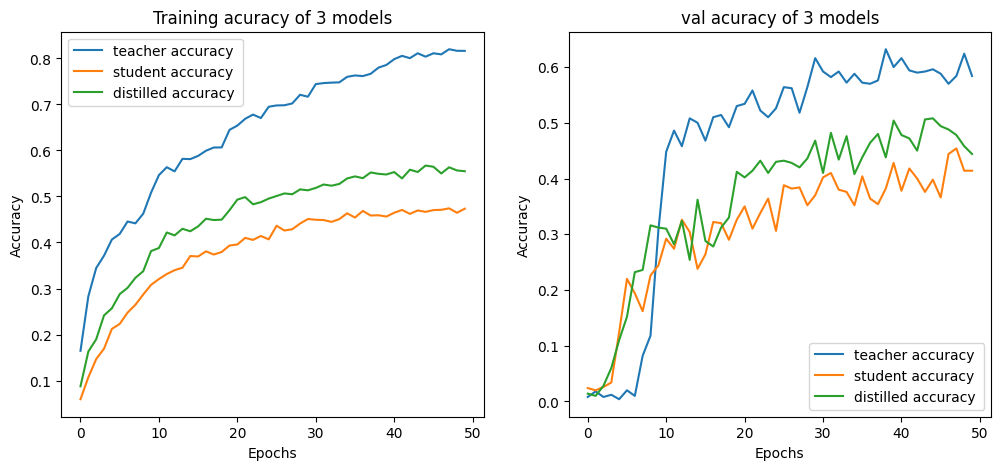

In [21]:

plt.figure(figsize=(12, 5))

# Training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='teacher accuracy ')
plt.plot(history1.history['accuracy'], label='student accuracy')
plt.plot(history2.history['dense_4_accuracy'], label='distilled accuracy')

plt.title('Training acuracy of 3 models')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='teacher accuracy ')
plt.plot(history1.history['val_accuracy'], label='student accuracy')
plt.plot(history2.history['val_dense_4_accuracy'], label='distilled accuracy')

plt.title('val acuracy of 3 models')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [1]:
train_way = 50
shot = 1
lr=0.001

def reduce_tensor1(xx):
    return tf.reduce_mean(tf.reshape(xx,(-1,2,xx.shape[-1])), axis=1)

def scheduler(epoch):
    global lr
    if (epoch+1) %10== 0:
        lr/= 2
    return lr
def cosine_distances(x):
    support, query_img=x
    normalize_a = tf.nn.l2_normalize(support,1)
    normalize_b = tf.nn.l2_normalize(query_img,1)
    distance = tf.matmul(normalize_b, tf.transpose(normalize_a)) #, transpose_b=True
    return distance

def cosine_distances_output_shape(input_shapes):
    # Get the batch size (None) and the feature dimension (100) from 'out_teach'
    batch_size = input_shapes[0][0]
    feature_dim = input_shapes[0][1]
    return (batch_size, feature_dim)
def combined_loss(y_true, y_pred):
    pred, cos = y_pred[0],y_pred[1]
    # Add a dimension to pred to make the rank 2
    pred = tf.expand_dims(pred, axis=0)
    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, pred)
    cosine_loss = -tf.reduce_mean(cos)  # Negative since we want to maximize similarity
    return 0.75 * cosine_loss + 0.25 * ce_loss

# def combined_loss(y_true, y_pred):
#     pred, cos = y_pred[0],y_pred[1]
#     ce_loss = tf.keras.losses.categorical_crossentropy(y_true, pred)
#     cosine_loss = -tf.reduce_mean(cos)  # Negative since we want to maximize similarity
#     return 0.75 * cosine_loss + 0.25 * ce_loss

dim  = (32,32,3)
cnn4 = conv_net(dim)
resNet_18 =  Model(inputs=resNetProto.input, outputs=resNetProto.layers[-2].output)
resNet_18.trainable=False
#resnet_model.trainable=False
if __name__ == "__main__":
    input_shape = (32,32,3)
    sample = Input(input_shape)
    teacher = resNet_18(sample)
    # teacher=tf.reshape(teacher, (-1,2,2,512))
    # teacher = MaxPooling2D()(teacher)
    # teacher = Flatten()(teacher)
    student = cnn4(sample)
    # out_teach = Lambda(reduce_tensor1, name="out_feature1")(teacher)
    out_stu = Lambda(reduce_tensor1, name="out_feature2")(student)

    #.........................................................
    pred=tf.keras.layers.Dense(100,'softmax')(out_stu)
    # cos= tf.nn.softmax(cosine_distances([out_teach, out_stu]), axis=1)
    cos = layers.Lambda(lambda x: tf.nn.softmax(cosine_distances(x)/2, axis=1),
                   output_shape=cosine_distances_output_shape,
                   name="cosine_softmax")([teacher, out_stu])

    # cos = Lambda(cosine_distances,output_shape=cosine_distances_output_shape, name="cosine_distance")([out_teach, out_stu])
    # cos = Softmax(axis=1, name="cosine_softmax")(cos)  # Apply softmax
    # print(out_teach.shape,out_stu.shape)
    distilModel = Model(sample, [pred,cos])
  #  optimizer = Adam(0.001)
    optimizer = SGD(learning_rate=0.01, momentum=0.9)
    distilModel.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics=[['accuracy'], ['accuracy']])
    print(distilModel.summary())
 #.........................................................................................
    train1_loader = Data_GeneratorDistill(way = train_way,  data ='cipher', k3=0,k4=500, shot = shot, num_batch=100)
    val1_loader = Data_GeneratorDistill(way = train_way,  data ='cipher', k3=500,k4=600, shot = shot, num_batch=10)

    reduce_lr = cb.ReduceLROnPlateau(monitor = 'loss', factor = 0.5,patience = 10, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor='val_loss', patience=15)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard()

    history2 = distilModel.fit(train1_loader,epochs = 50, batch_size=16,validation_data = val1_loader, shuffle=True, callbacks=[ lr_sched,reduce_lr, stopping,tensorboard])
    # distilModel.save('Model/distilModel_ClassifierRandomCrop_Backbone_cipher100.h5')
    # saveData(history.history,'Model/distilModel_ClassifierRandomCrop_cipher100.npy')

NameError: name 'conv_net' is not defined